In [3]:
#basic stats/math packages 

import pandas as pd
import numpy as np
import scipy.stats as stats

#visualization

import matplotlib.pyplot as plt


#bayesian modeling packages

import bambi as bmb
import pymc as pm
import arviz as az

#seed

RANDOM_SEED = 576

# Summary

This notebook documents how we will test the hypothesis that **taxonomists are more likely to assign the rank of species to a taxon if the taxon is threatened**. 

To test this hypothesis, participants of the survey get one of three similar abstract:

- one in which it is mentioned that the group is threatened (c1_t)
- one in which it is mentioned that the group is not threatened (c1_nt)
- one in which no mention of conservation status is made (c1_neutral)

To test this hypothesis, we will use a bayesian model to estimate the mean rates of acceptance for c1_t, c1_nt and c1_neutral. **We will consider the hypothesis to be confirmed if the 80% HDI of the difference between the posterior means of c1_t and c1_nt as well as the 80% HDI of the difference between the posterior means of c1_t and c1_neutral do not contain 0.**

Reporting:
 We will follow the guidelines in [Kruschke's 2021 Nature paper](https://www.nature.com/articles/s41562-021-01177-7/tables/1) (https://doi.org/10.1038/s41562-021-01177-7).

In additional exploratory analysis, we will use a bayesian regression model to investigate the role of additional independent variables such as the demographic questions of the survey, and potentially other methods. In any publication discussion these results, we will indicate explicitly which tests were pre-registered.

In [4]:
#the HDI interval we want to use
#this is arbitrary -- more informative to look at the distribution

hdi_choice = 0.80

# Load and prepare the data

In [53]:
#load the data

dfx = pd.read_csv('...')
dfx = dfx.loc[dfx['taxonomist?'] == 'taxonomist']
dfx = dfx.loc[(dfx.c1_agree != 'No response') |(dfx.c2_agree != 'No response') |(dfx.c3_agree != 'No response')]

#limit to conservation-case

df = dfx[['condition_c1','c1_agree','main_data']].copy()
df = df.loc[(df.c1_agree != 'No response') & df.main_data == 1]

# #make the categories meaningful

# df['condition_c1'].replace({1:'threatened',2:'abundant',3:'neutral'},inplace=True)

# #get the data for the model

counts = pd.crosstab(index = df.condition_c1, columns = df.c1_agree)

totals = counts.sum(axis=1).values.astype('int32')
observed = counts.iloc[:,1].values.astype('int32')

df

,condition_c1,c1_agree,main_data
0,Threatened,no,1
1,Abundant,no,1
2,Neutral,no,1
3,Neutral,no,1
4,Threatened,no,1
...,...,...,...
491,Threatened,no,1
494,Threatened,no,1
496,Neutral,no,1
498,Threatened,no,1


# Prior choice

We expect p to be closer to 0.5, and values closer to 0 and 1 to be more unlikely (but still reasonably likely). A beta-distribution with alpha and beta both 2 seems suitable in that respect: it makes values closer to 0.5 more likely, but values closer to 1 and 0 still sufficiently likely.

To check what influence the priors have, we will run the same model with a uniform prior (pm.Beta(1,1)) and pm.Beta(0.5,0.5). However, given the expected sample size this is unlikely to make a difference.


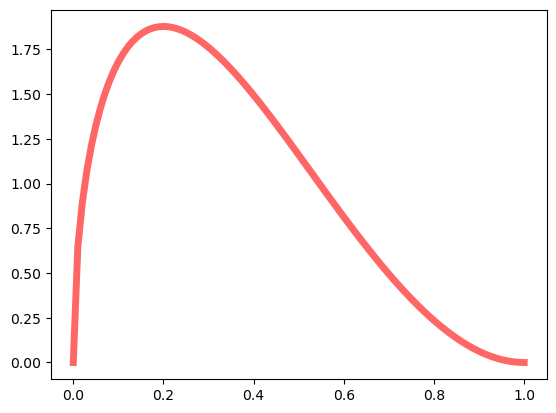

In [14]:
#prior we will use

alpha = 1.5
beta = 3

fig, ax = plt.subplots(1, 1)

x = np.linspace(0,
                1, 100)
ax.plot(x, stats.beta.pdf(x, alpha, beta),
       'r-', lw=5, alpha=0.6, label='beta pdf')


# estimate the proportion of 'agree' for each group

Note: we do not use a hierarchical model here as all groups are of the same size and we don't have any particular additional information about the population of groups. Hence, there is little to gain by using a multi-level model here.

In [46]:
coords = {"groups": counts.index.values}

with pm.Model(coords=coords) as c1_model:
    
    
    #prior for p    
    p = pm.Beta("p", alpha,beta, dims = 'groups')
    
    #binomial likelihood    
    y = pm.Binomial("y", n=totals, p=p, observed=observed,dims = 'groups')


In [47]:
# pm.model_graph.model_to_graphviz(model=c1_model)

In [48]:
with c1_model:
    trace1 = pm.sample(10000, chains = 4, tune=5000, return_inferencedata=True, random_seed = RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 42 seconds.


# check the sampling

In [41]:
#R-hat (we used three chains) and ESS

az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[Abundant],0.215,0.035,0.150,0.283,0.0,0.0,57370.0,31136.0,1.0
p[Neutral],0.171,0.033,0.112,0.233,0.0,0.0,59868.0,31944.0,1.0
p[Threatened],0.213,0.034,0.150,0.278,0.0,0.0,62993.0,31923.0,1.0


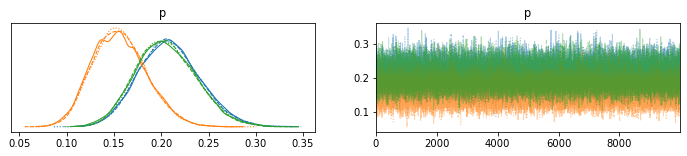

In [9]:
#traceplot

with c1_model:
    az.plot_trace(trace1)

divergences: 0
mean acceptance rate: 0.8209489074583114


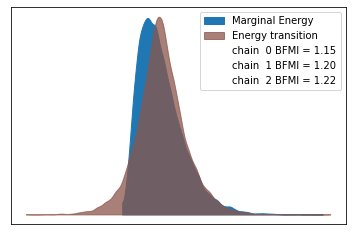

In [10]:
#see here: https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/sampler-stats.html


#print number of divergences, ideally 0
print(f'divergences: {trace1.sample_stats["diverging"].values.sum()}')

#print the acceptance rate
print(f'mean acceptance rate: {trace1.sample_stats["acceptance_rate"].values.mean()}')

#compare the overall distribution of the energy levels with the change of energy between successive samples. Ideally, they should be very similar
az.plot_energy(trace1, figsize=(6, 4));

# Posterior Predictive Checks

Note: this is rather unnecessary and uninformative, as the models just estimate proportions from a single proportion. 

In [11]:
with c1_model:
    ppc = pm.sample_posterior_predictive(
        trace1, random_seed=RANDOM_SEED
    )

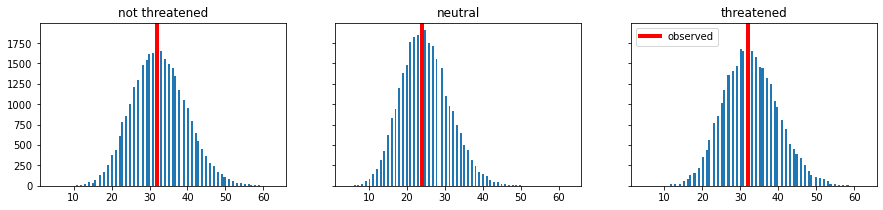

In [12]:
fig,axs = plt.subplots(ncols = 3, figsize = (15,3), sharey = True, sharex= True)

titles = {0:'not threatened',1:'neutral',2:'threatened'}


for ax, (key,value)in zip(axs.flat,titles.items()):
    ax.hist(ppc['y'].T[key], bins = 100)
    ax.set_title(titles[key])
    ax.axvline(observed[key],c = 'r',linestyle = '-',linewidth = 4,label = 'observed')

plt.legend(loc='upper left')
plt.show()
    

# inspect the results

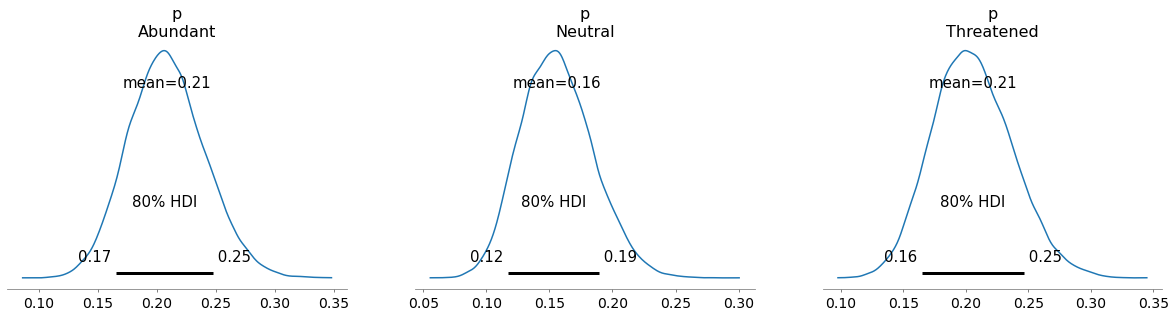

In [13]:
#plot the posterior distributions of p for the three groups

with c1_model:
    az.plot_posterior(trace1,hdi_prob=hdi_choice)

Text(0.5, 1.0, 'threatened - not threatened')

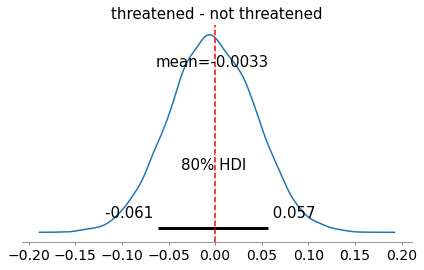

In [14]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,4))

az.plot_posterior(trace1.posterior['p'][:,:,2] - trace1.posterior['p'][:,:,0],ax=ax, hdi_prob=hdi_choice)
ax.axvline(0, c = 'r',linestyle ='--')
ax.set_title('threatened - not threatened', fontsize = 15)


Plot the chosen hdi, and check if 0 is within the interval. Note: it is more interesting to look at the distribution, but for the preregistration we use the inclusion of 0 in the interval as a decision rule.

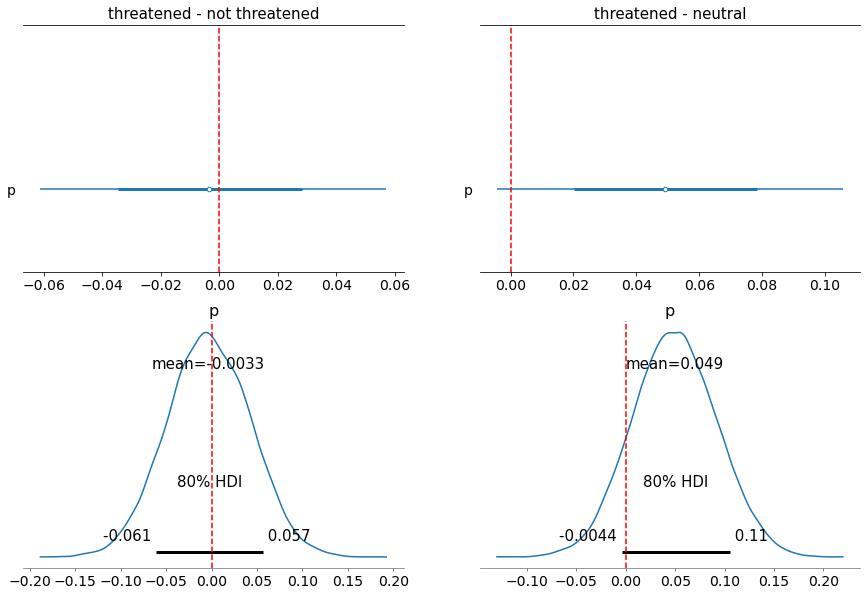

In [15]:
#plot the difference between 'threatened' and the other two groups to see if there is an interesting difference

fig, ax = plt.subplots(ncols = 2,nrows = 2, figsize = (15,10))

with c1_model:
    az.plot_forest(trace1.posterior['p'][:,:,2] - trace1.posterior['p'][:,:,0], ax = ax[0,0], hdi_prob=hdi_choice, combined = True)
    az.plot_forest(trace1.posterior['p'][:,:,2] - trace1.posterior['p'][:,:,1], ax = ax[0,1],hdi_prob=hdi_choice, combined = True)
    az.plot_posterior(trace1.posterior['p'][:,:,2] - trace1.posterior['p'][:,:,0], ax = ax[1,0], hdi_prob=hdi_choice)
    az.plot_posterior(trace1.posterior['p'][:,:,2] - trace1.posterior['p'][:,:,1], ax = ax[1,1],hdi_prob=hdi_choice)

ax[0,0].set_title('threatened - not threatened', fontsize = 15)
ax[0,1].set_title('threatened - neutral', fontsize = 15)


ax[0,0].axvline(0, c = 'r',linestyle ='--')
ax[0,1].axvline(0, c = 'r',linestyle ='--')
ax[1,0].axvline(0, c = 'r',linestyle ='--')
ax[1,1].axvline(0, c = 'r',linestyle ='--')

plt.show()

# Effect size: Cohen's d

[Cohen](https://www.taylorfrancis.com/books/mono/10.4324/9780203771587/statistical-power-analysis-behavioral-sciences-jacob-cohen) gives the following rule of thumb:

- 0.20: "small effect size".
- 0.50: "medium effect size".
- 0.80: "large effect size".

Our rule of thumb: the effect is practically meaningful (i.e. has at least a small effect size) in case the lowest point of the HDI is larger than 0.20.

Text(0.5, 1.0, 'effect size threatened - neutral')

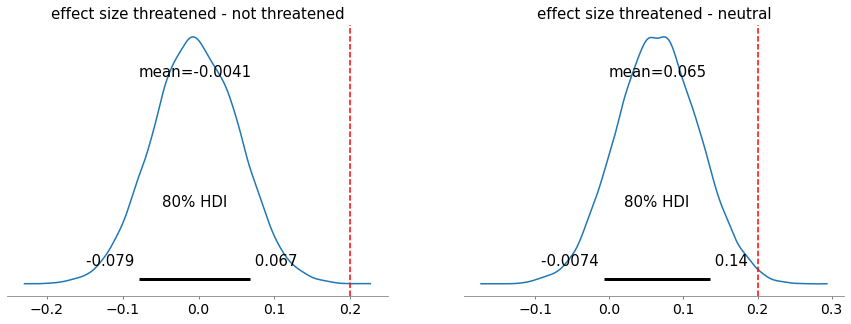

In [16]:
fig, ax = plt.subplots(ncols =2, figsize = (15,5))

with c1_model:
    
    az.plot_posterior(np.arcsin(np.sqrt((trace1.posterior['p'][:,:,2]))) -  np.arcsin(np.sqrt(trace1.posterior['p'][:,:,0])), hdi_prob = hdi_choice,ax = ax[0])
    az.plot_posterior(np.arcsin(np.sqrt((trace1.posterior['p'][:,:,2]))) -  np.arcsin(np.sqrt(trace1.posterior['p'][:,:,1])), hdi_prob = hdi_choice, ax = ax[1])

ax[0].axvline(0.20, c = 'r',linestyle ='--')
ax[1].axvline(0.20, c = 'r',linestyle ='--')

ax[0].set_title('effect size threatened - not threatened', fontsize = 15)
ax[1].set_title('effect size threatened - neutral', fontsize = 15)